In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ========= Preprocessing =========
def preprocess_dataset(df, label_cols, drop_cols=None, scaler=None):
    df = df.copy()
    y = df[label_cols].values.argmax(axis=1)
    if drop_cols is None:
        drop_cols = []
    X = df.drop(columns=label_cols + drop_cols)
    if scaler is None:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
    else:
        X_scaled = scaler.transform(X)
    return X_scaled, y, scaler

def create_dataloaders(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    return (
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(X_test, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.long),
        torch.tensor(y_test, dtype=torch.long),
    )

# ========= MLP Model =========
class CowHealthMLP(nn.Module):
    def __init__(self, input_dim, hidden1=64, hidden2=32, num_classes=6):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, num_classes)
        )
    def forward(self, x):
        return self.model(x)

# ========= Training =========
def train_mlp_model(model, X_train, y_train, X_val, y_val, epochs=30, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_loss_history = []
    val_loss_history = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        train_loss_history.append(loss.item())

        model.eval()
        with torch.no_grad():
            val_output = model(X_val)
            val_loss = criterion(val_output, y_val)
            val_loss_history.append(val_loss.item())

        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {loss.item():.4f} - Val Loss: {val_loss.item():.4f}")

    return model, train_loss_history, val_loss_history

# ========= Evaluation =========
def evaluate_model(model, X, y, label_names, dataset_name=""):
    model.eval()
    with torch.no_grad():
        preds = model(X).argmax(dim=1)
        print(f"\n📊 Classification Report ({dataset_name}):")
        print(classification_report(y, preds, target_names=label_names))

        cm = confusion_matrix(y, preds)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
                    xticklabels=label_names, yticklabels=label_names)
        plt.title(f'Confusion Matrix - {dataset_name}')
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()

# ========= Pipeline =========
def run_full_pipeline(train_test_csv, validation_csv, label_cols, drop_cols=None, epochs=30):
    print("📂 Loading datasets...")
    df_train = pd.read_csv(train_test_csv)
    df_val = pd.read_csv(validation_csv)

    print("🧹 Preprocessing...")
    X_full, y_full, scaler = preprocess_dataset(df_train, label_cols, drop_cols)
    X_train, X_test, y_train, y_test = create_dataloaders(X_full, y_full)

    X_val, y_val, _ = preprocess_dataset(df_val, label_cols, drop_cols, scaler=scaler)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)

    print("🏋️ Training model...")
    model = CowHealthMLP(input_dim=X_train.shape[1], num_classes=len(label_cols))
    model, train_loss, val_loss = train_mlp_model(model, X_train, y_train, X_test, y_test, epochs=epochs)

    print("\n✅ Evaluation on Test Set")
    evaluate_model(model, X_test, y_test, label_names=label_cols, dataset_name="Test")

    print("\n✅ Evaluation on Validation Set")
    evaluate_model(model, X_val_tensor, y_val_tensor, label_names=label_cols, dataset_name="Validation")

    print("\n📈 Loss curves:")
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label='Train Loss', marker='o')
    plt.plot(val_loss, label='Validation Loss', marker='x')
    plt.title("Training vs Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


c:\Users\lamia\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


📂 Loading datasets...
🧹 Preprocessing...
🏋️ Training model...
Epoch 5/30 - Train Loss: 1.7789 - Val Loss: 1.7708
Epoch 10/30 - Train Loss: 1.7466 - Val Loss: 1.7389
Epoch 15/30 - Train Loss: 1.7152 - Val Loss: 1.7074
Epoch 20/30 - Train Loss: 1.6824 - Val Loss: 1.6744
Epoch 25/30 - Train Loss: 1.6469 - Val Loss: 1.6391
Epoch 30/30 - Train Loss: 1.6094 - Val Loss: 1.6025

✅ Evaluation on Test Set

📊 Classification Report (Test):
               precision    recall  f1-score   support

      oestrus       0.38      0.40      0.39      3599
      calving       0.41      0.92      0.56      3731
     lameness       0.56      0.25      0.34      3729
     mastitis       0.37      0.42      0.40      3727
other_disease       0.39      0.17      0.24      3713
           OK       0.28      0.17      0.21      3208

     accuracy                           0.39     21707
    macro avg       0.40      0.39      0.36     21707
 weighted avg       0.40      0.39      0.36     21707



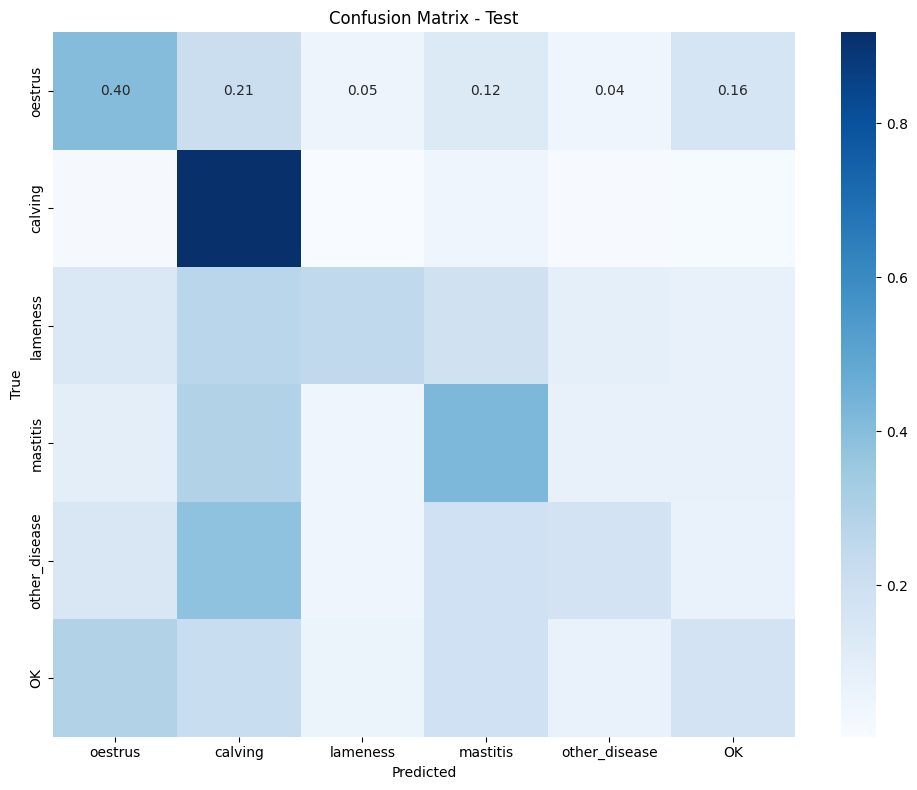


✅ Evaluation on Validation Set

📊 Classification Report (Validation):
               precision    recall  f1-score   support

      oestrus       0.36      0.37      0.36      2000
      calving       0.41      0.92      0.57      2072
     lameness       0.55      0.26      0.35      2072
     mastitis       0.35      0.39      0.37      2071
other_disease       0.38      0.18      0.24      2063
           OK       0.27      0.17      0.21      1782

     accuracy                           0.39     12060
    macro avg       0.39      0.38      0.35     12060
 weighted avg       0.39      0.39      0.35     12060



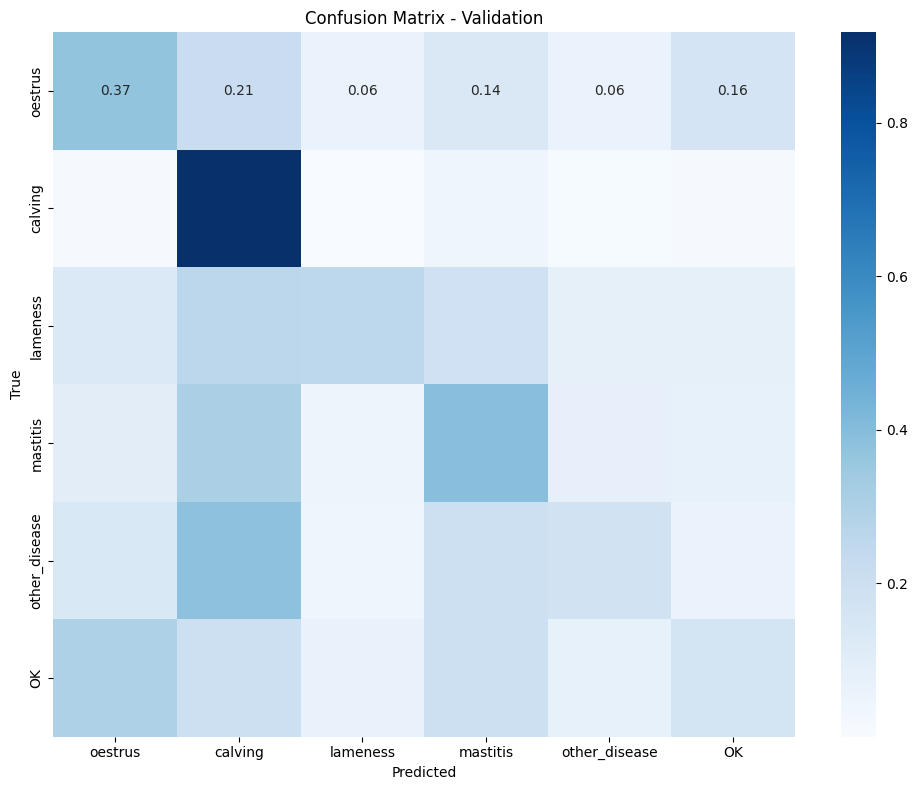


📈 Loss curves:


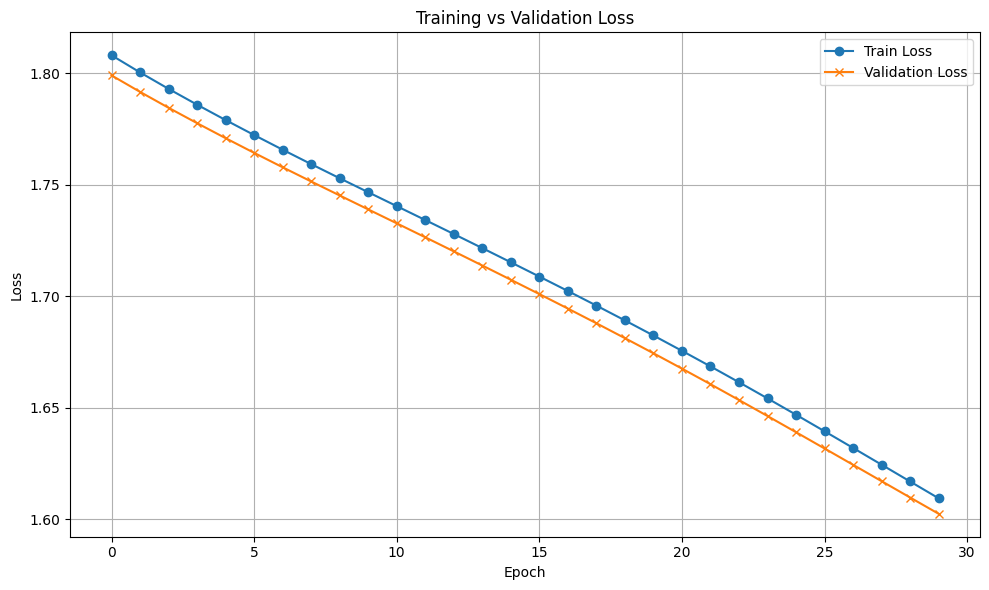

In [3]:


train_test_csv_path = r"C:/Users/lamia/Downloads/augmented_dataset1_trainval.csv"
validation_csv_path = r"C:/Users/lamia/Downloads/augmented_dataset1_holdout.csv"

label_columns = ['oestrus', 'calving', 'lameness', 'mastitis', 'other_disease', 'OK']
drop_columns = ['cow', 'duration_hours']

run_full_pipeline(
    train_test_csv=train_test_csv_path,
    validation_csv=validation_csv_path,
    label_cols=label_columns,
    drop_cols=drop_columns,
    epochs=30
)


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ========= Preprocessing =========
def preprocess_dataset(df, label_cols, drop_cols=None, scaler=None):
    df = df.copy()
    y = df[label_cols].values.argmax(axis=1)
    if drop_cols is None:
        drop_cols = []
    X = df.drop(columns=label_cols + drop_cols)
    if scaler is None:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
    else:
        X_scaled = scaler.transform(X)
    return X_scaled, y, scaler

def compute_class_weights(y, num_classes):
    weights = compute_class_weight(class_weight='balanced', classes=np.arange(num_classes), y=y)
    return torch.tensor(weights, dtype=torch.float32)

def create_dataloaders(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    return (
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(X_test, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.long),
        torch.tensor(y_test, dtype=torch.long),
    )

# ========= Model =========
class CowHealthMLP(nn.Module):
    def __init__(self, input_dim, hidden1=128, hidden2=64, num_classes=6):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.BatchNorm1d(hidden1),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden1, hidden2),
            nn.BatchNorm1d(hidden2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden2, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# ========= Training =========
def train_mlp_model(model, X_train, y_train, X_val, y_val, num_classes, epochs=30, lr=0.001):
    class_weights = compute_class_weights(y_train.numpy(), num_classes)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_loss_history = []
    val_loss_history = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        train_loss_history.append(loss.item())

        model.eval()
        with torch.no_grad():
            val_output = model(X_val)
            val_loss = criterion(val_output, y_val)
            val_loss_history.append(val_loss.item())

        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {loss.item():.4f} - Val Loss: {val_loss.item():.4f}")

    return model, train_loss_history, val_loss_history

# ========= Evaluation =========
def evaluate_model(model, X, y, label_names, dataset_name=""):
    model.eval()
    with torch.no_grad():
        preds = model(X).argmax(dim=1)
        print(f"\n📊 Classification Report ({dataset_name}):")
        print(classification_report(y, preds, target_names=label_names))

        cm = confusion_matrix(y, preds)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
                    xticklabels=label_names, yticklabels=label_names)
        plt.title(f'Confusion Matrix - {dataset_name}')
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()

# ========= Full Pipeline =========
def run_full_pipeline(train_test_csv, validation_csv, label_cols, drop_cols=None, epochs=30):
    print("📂 Loading datasets...")
    df_train = pd.read_csv(train_test_csv)
    df_val = pd.read_csv(validation_csv)

    print("🧹 Preprocessing...")
    X_all, y_all, scaler = preprocess_dataset(df_train, label_cols, drop_cols)
    X_train, X_test, y_train, y_test = create_dataloaders(X_all, y_all)

    X_val, y_val, _ = preprocess_dataset(df_val, label_cols, drop_cols, scaler)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)

    model = CowHealthMLP(input_dim=X_train.shape[1], num_classes=len(label_cols))

    print("🏋️ Training model...")
    model, train_loss, val_loss = train_mlp_model(
        model, X_train, y_train, X_test, y_test,
        num_classes=len(label_cols), epochs=epochs
    )

    print("\n✅ Evaluation on Test Set")
    evaluate_model(model, X_test, y_test, label_names=label_cols, dataset_name="Test")

    print("\n✅ Evaluation on Validation Set")
    evaluate_model(model, X_val_tensor, y_val_tensor, label_names=label_cols, dataset_name="Validation")

    print("\n📈 Loss Comparison:")
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label='Train Loss', marker='o')
    plt.plot(val_loss, label='Validation Loss', marker='x')
    plt.title("Training vs Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return model, scaler


📂 Loading datasets...
🧹 Preprocessing...
🏋️ Training model...
Epoch 5/30 - Train Loss: 1.7276 - Val Loss: 1.7304
Epoch 10/30 - Train Loss: 1.6048 - Val Loss: 1.6372
Epoch 15/30 - Train Loss: 1.5297 - Val Loss: 1.5444
Epoch 20/30 - Train Loss: 1.4777 - Val Loss: 1.4668
Epoch 25/30 - Train Loss: 1.4379 - Val Loss: 1.4057
Epoch 30/30 - Train Loss: 1.3999 - Val Loss: 1.3575

✅ Evaluation on Test Set

📊 Classification Report (Test):
               precision    recall  f1-score   support

      oestrus       0.46      0.53      0.49      3599
      calving       0.57      0.93      0.71      3731
     lameness       0.51      0.61      0.56      3729
     mastitis       0.51      0.43      0.46      3727
other_disease       0.54      0.27      0.36      3713
           OK       0.28      0.18      0.22      3208

     accuracy                           0.50     21707
    macro avg       0.48      0.49      0.47     21707
 weighted avg       0.48      0.50      0.47     21707



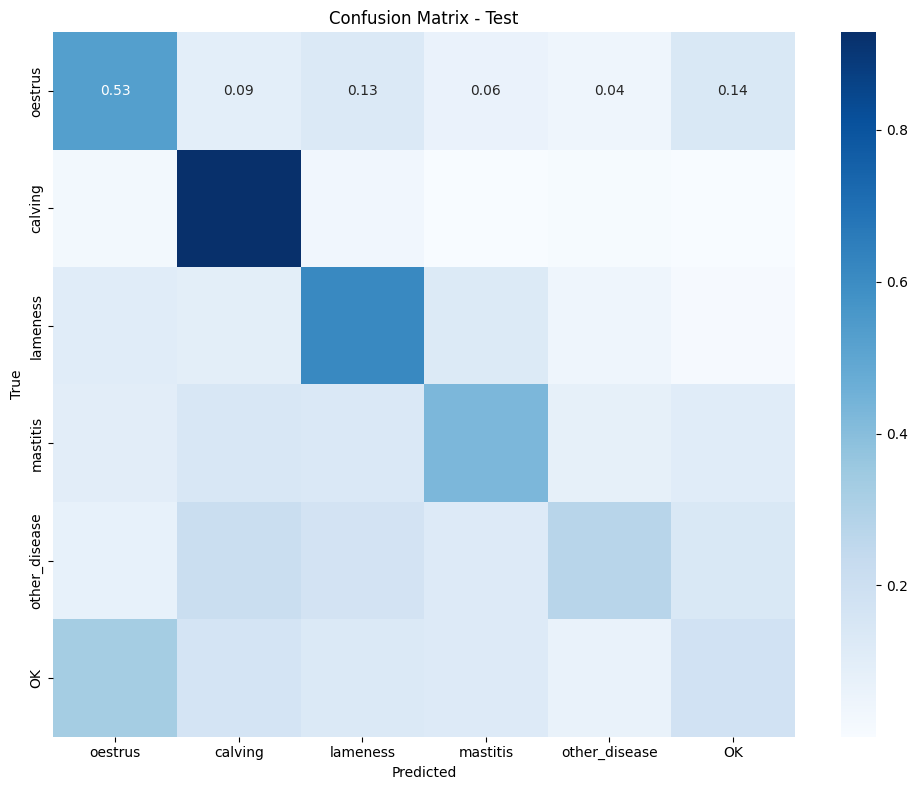


✅ Evaluation on Validation Set

📊 Classification Report (Validation):
               precision    recall  f1-score   support

      oestrus       0.46      0.52      0.48      2000
      calving       0.57      0.93      0.71      2072
     lameness       0.52      0.63      0.57      2072
     mastitis       0.51      0.42      0.46      2071
other_disease       0.54      0.28      0.37      2063
           OK       0.31      0.19      0.24      1782

     accuracy                           0.50     12060
    macro avg       0.48      0.50      0.47     12060
 weighted avg       0.49      0.50      0.48     12060



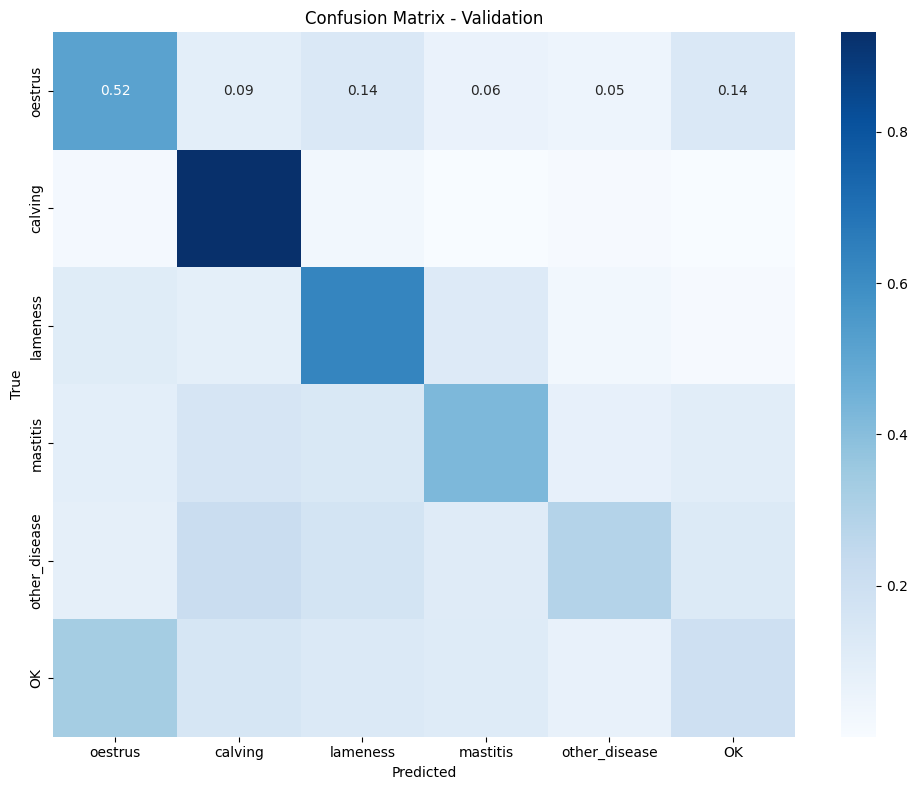


📈 Loss Comparison:


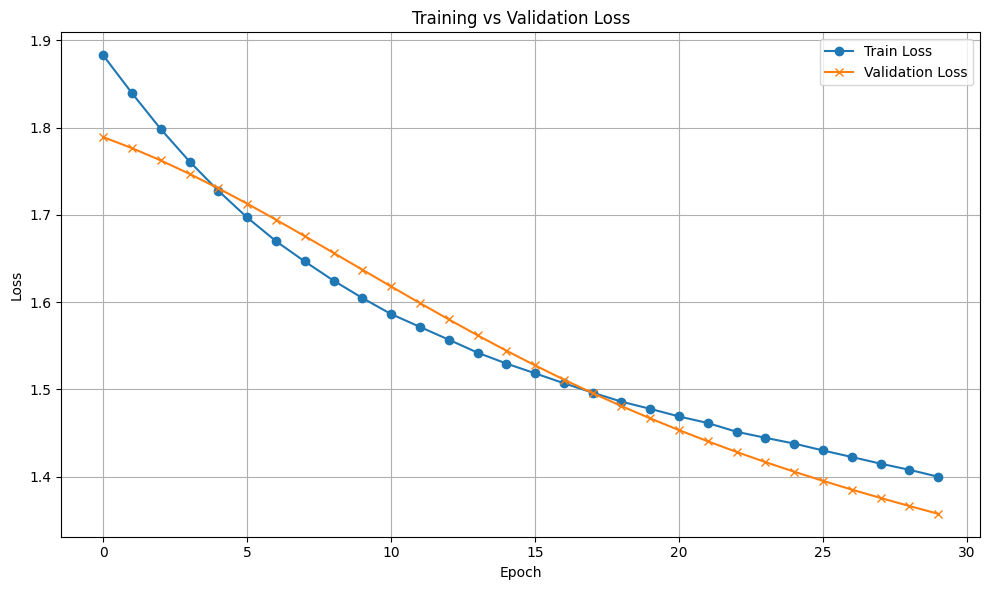

(CowHealthMLP(
   (model): Sequential(
     (0): Linear(in_features=22, out_features=128, bias=True)
     (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU()
     (3): Dropout(p=0.4, inplace=False)
     (4): Linear(in_features=128, out_features=64, bias=True)
     (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (6): ReLU()
     (7): Dropout(p=0.3, inplace=False)
     (8): Linear(in_features=64, out_features=6, bias=True)
   )
 ),
 StandardScaler())

In [6]:

train_csv = r"C:/Users/lamia/Downloads/augmented_dataset1_trainval.csv"
val_csv  = r"C:/Users/lamia/Downloads/augmented_dataset1_holdout.csv"

label_columns = ['oestrus', 'calving', 'lameness', 'mastitis', 'other_disease', 'OK']
drop_columns = ['cow', 'duration_hours']

run_full_pipeline(train_csv, val_csv, label_cols=label_columns, drop_cols=drop_columns, epochs=30)
